In [27]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="frame will be truncated. Increase NFFT to avoid.")

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import math
import os
import python_speech_features as speech_feat
import glob
import wave
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from sklearn import preprocessing
from scipy.signal import butter, lfilter, filtfilt, freqz
from dtaidistance import dtw
import pickle
from scipy import signal

# from project_strings import *
# import audio_processing as ap
# import opensmile

# template_R_X_a = pd.read_csv('templates/budsLive-focused-new/template_R_X_a_f_hfp.csv', header=None)[0]
# template_R_Y_a = pd.read_csv('templates/budsLive-focused-new/template_R_Y_a_f_hfp.csv', header=None)[0]
# template_R_Z_a = pd.read_csv('templates/budsLive-focused-new/template_R_Z_a_f_hfp.csv', header=None)[0]
# template_L_X_a = pd.read_csv('templates/budsLive-focused-new/template_L_X_a_f_hfp.csv', header=None)[0]
# template_L_Y_a = pd.read_csv('templates/budsLive-focused-new/template_L_Y_a_f_hfp.csv', header=None)[0]
# template_L_Z_a = pd.read_csv('templates/budsLive-focused-new/template_L_Z_a_f_hfp.csv', header=None)[0]

class Device_Features:
    def __init__(self, slice, sampling_rate, magnitudes, freqs):
        self.data = slice
        self.sr = sampling_rate
        self.magnitudes =  magnitudes
        self.freqs = freqs

    def zcr(self):
        ans = 0
        signalDuration = float(len(self.data)) / float(self.sr)
        for i in range(1, len(self.data)):
            if self.data[i] * self.data[i - 1] < 0:
                ans += 1
        ans /= signalDuration
        return ans

    def SPlevel(self):
        data = self.data
        energy = 0
        for value in data:
            energy = energy + (float(value)*float(value))
        power = 20 * math.log10((math.sqrt(energy)+0.0001) / float(len(data)))
        return power

    def Spec_Cent(self):
        magnitudes = self.magnitudes
        freqs = self.freqs
        return np.sum(magnitudes * freqs) / np.sum(magnitudes)

    def Spec_Spread(self):
        magnitudes = self.magnitudes
        freqs = self.freqs
        SC = self.Spec_Cent()
        M2 = np.sum(magnitudes * (freqs**2)) / np.sum(magnitudes)
        if np.sum(magnitudes) == 0:
            return 0
        else:
            return math.sqrt(M2 - SC**2)

    def Spec_Rolloff(self):
        magnitudes = self.magnitudes
        sr = self.sr
        spectralSum = 0
        for i in magnitudes:
            spectralSum += i
        rolloffSum = 0
        rolloffIndex = 0
        for index, value in enumerate(magnitudes):
            rolloffSum += value
            if rolloffSum > 0.85*spectralSum:
                rolloffIndex = index
                break
        return rolloffIndex*((sr/2.0)/len(magnitudes))

    def Spec_Flatness(self):
        magnitudes = self.magnitudes
        sr = self.sr
        num = 0
        den = 0

        for i in magnitudes:
            if i != 0:
                num += math.log(i)
                den += i
        if den != 0:
            return math.exp(num/float(len(magnitudes)))/(den/float(len(magnitudes)))
        else:
            return math.exp(1/float(len(magnitudes)))/(1/float(len(magnitudes)))

    def Quartile_Range(self):
        data = self.data
        data = np.abs(data)

        return np.quantile(data, 0.75) - np.quantile(data, 0.25)

    def Chroma(self):
        data = self.data
        magnitudes = self.magnitudes
        sr = self.sr

        # # implementing through PyAudio
        # nFFT = int(len(data))  # half of window_size
        # nChroma, nFreqsPerChroma = audioFeatureExtraction.stChromaFeaturesInit(nFFT, sr)
        # chroma_feat = audioFeatureExtraction.stChromaFeatures(data, sr, nChroma, nFreqsPerChroma)

        # copying the java library
        chroma = np.zeros(12)
        from audiolazy.lazy_midi import freq2midi
        df = (sr/2.0)/len(magnitudes)
        for index, value in enumerate(magnitudes):
            frequencyi = df*index
            if frequencyi == 0:
                pitch = 0
            else:
                pitch = freq2midi(frequencyi)

            pitchClass = int(pitch%12)
            if pitchClass < 0:
                pitchClass += 12
            chroma[pitchClass] += value

        maxElement = np.max(chroma)
        for index, value in enumerate(chroma):
            chroma[index] = value/maxElement
        return chroma.tolist()

    def Energy(self):
        data = self.data

        energy = 0
        for i in data:
            energy += i*i
        return energy/float(len(data))

def cough_post_processing(test_file_features, save_cough_snippets = False, audio_path = None, jump_size = 0.1):

    predictions = test_file_features['prediction'].tolist()

    # step 0, check the weak cough test
    for index, value in enumerate(predictions):
        if predictions[index] == 'cough':
            if test_file_features.iloc[index]['SPlevel'] < -77:
                predictions[index] = 'non-cough'
            elif test_file_features.iloc[index]['std'] < 0.011:
                predictions[index] = 'non-cough'
            elif test_file_features.iloc[index]['mfcc_00_std'] < 0.51:
                predictions[index] = 'non-cough'


    # step 1: converting a non-cough that is surrounded by cough predictions
    for index, value in enumerate(predictions[:-2]):
        if predictions[index] == 'cough' and predictions[index+2] == 'cough':
            predictions[index+1] = 'cough'

    # step 2:
    cough_like_numbers = 0
    cough_start_index, cough_stop_index = 0, 0
    found_a_cough = False
    post_predictions = [0] * len(predictions)
    for index, value in enumerate(predictions):
        if index in [0, 1, 2]:
            continue
        else:
            if predictions[index] == "cough":
                if found_a_cough:
                    index += 1
                    continue
                elif predictions[index - 1] == "cough" and predictions[index - 2] == "cough":
                    # you might need to add the next line if the jump size is smaller than 0.1
                    # and predictions[index - 2] == "cough" and predictions[index - 3] == "cough":
                    found_a_cough = True
                    cough_like_numbers += 1
                    cough_start_index = index - 2
                    index += 1
            else:
                if found_a_cough:
                    found_a_cough = False
                    cough_stop_index = index
                    post_predictions[cough_start_index:cough_stop_index] = [1] * (cough_stop_index - cough_start_index)
                    if save_cough_snippets:
                        sr_test, wav_test = sp.io.wavfile.read(audio_path)
                        audio_folder = '/'.join(audio_path.split('/')[:-1])
                        create_path(audio_folder+'/snippets')
                        sp.io.wavfile.write(audio_folder+'/snippets/' + audio_path.split('/')[-1][:-4] + "_cough_" +
                                            str(jump_size * (cough_start_index-2)) + '.wav', sr_test,
                                            wav_test[int(jump_size * sr_test * (cough_start_index-2)):int(
                                                jump_size * sr_test * (cough_stop_index+2))])
                else:
                    continue
    return post_predictions

def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)

# shift < 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

def label_file_to_DF(txt_address):
    with open(txt_address) as f:
        start_time = []
        stop_time = []
        label = []
        for line in f:
            splitted = line.split()
            if splitted[2] == 'Start':
                start_time.append('%.4f'%float(splitted[0]))
            elif splitted[2] == 'End':
                stop_time.append('%.4f'%float(splitted[0]))
                label.append('cough')
            else:
                start_time.append('%.4f'%float(splitted[0]))
                stop_time.append('%.4f'%float(splitted[1]))
                label.append(splitted[2])

    label_DF = pd.DataFrame(data= {'start_times': start_time, 'stop_times': stop_time, 'label': label})
    return label_DF


def wave_file_to_device_feature_table_sliding(wav_path, win_size, jump_size, normalization =  False, label = None, downsampling_freq = None, hard_max = None):
    # creating features from field data
    sr, wav = sp.io.wavfile.read(wav_path)
    ####################################
    # picking the channel with higher amplitude if there is two channels
    try:
        if np.sum(np.absolute(np.array(wav[:, 0]))) > np.sum(np.absolute(np.array(wav[:, 1]))):
            wav = np.array(wav[:, 0])
            print("channel one")
        else:
            wav = np.array(wav[:, 1])
            print("channel two")
    except:
        print("single channel file")


    # expanding the resolution to float so it doesn't go out of range if wav is 16 bit int
    wav = wav.astype(int)

    # downsampling the file
    if downsampling_freq != None:
        downsampling_ratio = int(sr / downsampling_freq)
        wav = sp.signal.decimate(wav, downsampling_ratio)
        sr = downsampling_freq

    # normalizing the amplitude
    if normalization:
        if hard_max == None:
            max_val = max(wav)
            min_val = min(wav)
        else:
            max_val = max(max(wav), hard_max)
            min_val = max(min(wav), hard_max*-1)
        max_min_max = max(abs(max_val), abs(min_val))
        normalization_ratio = max_min_max * 2
        wav = (wav + max_min_max) / normalization_ratio - 0.5
    else:
        normalization_ratio = 1

    # rounding the digits after decimal point to a certain number
    wav = np.round(wav, decimals=5)
    #####################################
    feature_table = pd.DataFrame()
    for i in range(0, int((len(wav)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav):
            break
        else:
            wave_piece = wav[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]
            feature_row_per_sub = wave_slice_to_device_features(wave_piece, sr)
            if feature_table.empty:
                feature_table = feature_row_per_sub
            else:
                feature_table = pd.concat([feature_table, feature_row_per_sub], axis=0)
    if normalization:
        feature_table['normalization_ratio'] = normalization_ratio

    if label != None:
        feature_table['label'] = label

    return feature_table

def normalize_DF(df):
    x = df.values  # returns a numpy array
    columns = df.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns= columns)
    return df

def IMU_DTW_test(IMU_DF):
    template_R_X_a = pickle.load(open('templates/manual/template_R_X_a_f', 'rb'))
    template_R_Y_a = pickle.load(open('templates/manual/template_R_Y_a_f', 'rb'))
    template_R_Z_a = pickle.load(open('templates/manual/template_R_Z_a_f', 'rb'))
    template_L_X_a = pickle.load(open('templates/manual/template_L_X_a_f', 'rb'))
    template_L_Y_a = pickle.load(open('templates/manual/template_L_Y_a_f', 'rb'))
    template_L_Z_a = pickle.load(open('templates/manual/template_L_Z_a_f', 'rb'))

    jump_size = 10
    win_size = 50
    distance_list = []
    IMU_DF = IMU_DF[[' L_ACC_X_f', ' L_ACC_Y_f', ' L_ACC_Z_f', ' R_ACC_X_f', ' R_ACC_Y_f', ' R_ACC_Z_f']]
    for i in range(0, int(IMU_DF.shape[0] / jump_size)):
        if int(i * jump_size + win_size) > IMU_DF.shape[0]:
            break
        else:
            IMU_piece = IMU_DF.iloc[int(i * jump_size):int(i * jump_size + win_size)]
            alignment_R_X_a = dtw.distance(IMU_piece[' R_ACC_X_f'].tolist(), template_R_X_a.tolist())
            alignment_R_Y_a = dtw.distance(IMU_piece[' R_ACC_Y_f'].tolist(), template_R_Y_a.tolist())
            alignment_R_Z_a = dtw.distance(IMU_piece[' R_ACC_Z_f'].tolist(), template_R_Z_a.tolist())
            alignment_L_X_a = dtw.distance(IMU_piece[' L_ACC_X_f'].tolist(), template_L_X_a.tolist())
            alignment_L_Y_a = dtw.distance(IMU_piece[' L_ACC_Y_f'].tolist(), template_L_Y_a.tolist())
            alignment_L_Z_a = dtw.distance(IMU_piece[' L_ACC_Z_f'].tolist(), template_L_Z_a.tolist())
            distance_list.append((alignment_R_X_a * alignment_R_Y_a * alignment_R_Z_a * alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a)
                                 ** (1 / float(6)))

    plt.figure(figsize=(15, 5))
    plt.plot(distance_list)
    # plt.ylim([0, 5000])
    plt.savefig('distance.png')

    return distance_list

def process_the_chunk(top_index, chunk_size, wav_chunk, sr, IMU_chunk, enable_IMU, residual_wav, residual_IMU,
                      model, win_size, jump_size, post_processing, feature_list, silent_threshold, IMU_template_df):



    prediction_list = []
    distance_list = []
    wav_chunk = np.concatenate((residual_wav, wav_chunk), axis=None)
    IMU_chunk = pd.concat([residual_IMU, IMU_chunk])


    # looping through the chunk for prediction
    for i in range(0, int((len(wav_chunk)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav_chunk):
            wave_piece = wav_chunk[int(i * sr * jump_size):]
            # IMU_piece = IMU_chunk.iloc[int(i * 80 * jump_size + 80 * win_size):]
        else:
            wave_piece = wav_chunk[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]

        feature_row_per_sub = wave_slice_to_device_features(wave_piece, sr)
        if feature_row_per_sub['SPlevel'][0] < silent_threshold:
            prediction_list.append(0)
            distance_list.append(10000)
        else:
            selected_features = feature_row_per_sub[feature_list]
            prediction = model.predict(selected_features)[0]

            if prediction == 'cough':
                prediction_list.append(2)
                if enable_IMU:
                    j = 0
                    distance = 10000
                    while j* jump_size * 50 + 20 < len(IMU_chunk):
                        IMU_piece = IMU_chunk.iloc[int(j* jump_size * 50):int(j* jump_size * 50 + 20)]
                        alignment_L_X_a = dtw.distance(IMU_piece['ACC_X_f'].tolist(), IMU_template_df['acc_x'].tolist())
                        alignment_L_Y_a = dtw.distance(IMU_piece['ACC_Y_f'].tolist(), IMU_template_df['acc_y'].tolist())
                        alignment_L_Z_a = dtw.distance(IMU_piece['ACC_Z_f'].tolist(), IMU_template_df['acc_z'].tolist())
                        distance = min(distance, (alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(3)))
                        j += 1
                    distance_list.append(distance)
            else:
                prediction_list.append(1)
                distance_list.append(10000)

    final_cough_results = pd.DataFrame(columns=['start_time', 'end_time', 'duration', 'intensity', 'type'])
    if post_processing:
        index = 0
        cough_start_list = []
        cough_end_list = []
        post_prediction_list = prediction_list.copy()
        while index < (len(prediction_list[:-3])):
            if prediction_list[index] == 2 and prediction_list[index + 3] == 2:
                post_prediction_list[index + 1] = 2
                post_prediction_list[index + 2] = 2
                index += 4
            else:
                index += 1

        index = 0
        cough_happening = False
        while index < (len(post_prediction_list)):
            if post_prediction_list[index] == 2 and not cough_happening:
                if index == (len(post_prediction_list) -1):
                    cough_start_list.append(index)
                    cough_end_list.append(index+1)
                    break
                else:
                    cough_happening = True
                    cough_start_list.append(index)
                    index += 1
                    continue
            elif cough_happening and post_prediction_list[index] != 2:
                cough_happening = False
                cough_end_list.append(index)
                index += 1
                continue
            elif cough_happening and index == (len(post_prediction_list)-1):
                cough_end_list.append(index+1)
                break
            else:
                index += 1

        index = 0
        while index < len(cough_start_list):
            cough_duration = win_size + (cough_end_list[index] - cough_start_list[index] -1)* jump_size
            if cough_duration <= 0.5:
                post_prediction_list[cough_start_list[index]:cough_end_list[index]] = [0]*(cough_end_list[index] - cough_start_list[index])
                del cough_start_list[index]
                del cough_end_list[index]
            else:
                index += 1


        if enable_IMU:
            post_prediction_list_IMU = post_prediction_list.copy()
            for index, value in enumerate(cough_start_list):
                if min(distance_list[cough_start_list[index]:cough_end_list[index]]) > 4500:
                    post_prediction_list_IMU[cough_start_list[index]:cough_end_list[index]] = [1] * (cough_end_list[index] - cough_start_list[index])
                else:
                    cough_piece = wav_chunk[int((cough_start_list[index] + 1) * sr * jump_size):int(
                        (cough_end_list[index] - 1) * sr * jump_size + sr * win_size)]
                    cough_duration = win_size + (cough_end_list[index] - cough_start_list[index] - 1) * jump_size
                    cough_intensity = 20 * math.log10(np.sum(np.power(cough_piece * 2, 2))) / cough_duration
                    cough_start_time = chunk_size * top_index + (cough_start_list[index] + 1) * jump_size
                    cough_end_time = chunk_size * top_index + (cough_end_list[index] - 1) * jump_size + win_size
                    cough_results_this = pd.DataFrame(
                        {'start_time': [cough_start_time],
                         'end_time': [cough_end_time],
                         'duration': [cough_end_time - cough_start_time],
                         'intensity': [cough_intensity],
                         'type': ['dry']})
                    final_cough_results = pd.concat([final_cough_results, cough_results_this])

            prediction_dic = {'predictions': prediction_list, 'post_prediction': post_prediction_list, 'post_pred_IMU': post_prediction_list_IMU}
        else:
            prediction_dic = {'predictions': prediction_list, 'post_prediction': post_prediction_list}

    else:
        prediction_dic = {'predictions': prediction_list}

    return prediction_dic, final_cough_results, distance_list, residual_wav, residual_IMU


def audio_to_features(wav_chunk, sr, win_size, jump_size):
    feature_table = pd.DataFrame()
    for i in range(0, int((len(wav_chunk)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav_chunk):
            wave_piece = wav_chunk[int(i * sr * jump_size):]
        else:
            wave_piece = wav_chunk[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]

        feature_row_per_sub = wave_slice_to_device_features(wave_piece, sr)


        if feature_table.empty:
            feature_table = feature_row_per_sub
        else:
            feature_table = pd.concat([feature_table, feature_row_per_sub])

    return feature_table.reset_index()

def generate_opensmile_features_from_wav_sliding(wav, sr, win_size, jump_size):
    # looping through the chunk for prediction
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals, )
    feature_table =pd.DataFrame()
    for i in range(0, int((len(wav)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav):
            wave_piece = wav[int(i * sr * jump_size):]
        else:
            wave_piece = wav[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]
        sp.io.wavfile.write('temp.wav', sr, wave_piece.astype(np.int16))
        wav_features_this = smile.process_file('temp.wav')
        wav_features_this['piece_index'] = i
        if feature_table.empty:
            feature_table = wav_features_this
        else:
            feature_table = pd.concat([feature_table, wav_features_this])
    return feature_table


def process_audio_chunk(wav_chunk, sr, model, win_size, jump_size, post_processing, feature_list, silent_threshold):

    prediction_list = []
    distance_list = []

    # looping through the chunk for prediction
    for i in range(0, int((len(wav_chunk)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav_chunk):
            wave_piece = wav_chunk[int(i * sr * jump_size):]
        else:
            wave_piece = wav_chunk[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]

        feature_row_per_sub = wave_slice_to_device_features(wave_piece, sr)
        if feature_row_per_sub['SPlevel'][0] < silent_threshold:
            prediction_list.append(0)
            distance_list.append(10000)
        else:
            selected_features = feature_row_per_sub[feature_list]
            prediction = model.predict(selected_features)[0]

            if prediction == 'cough':
                prediction_list.append(2)

            else:
                prediction_list.append(1)
                distance_list.append(10000)

    final_cough_results = pd.DataFrame(columns=['start_time', 'end_time', 'duration', 'intensity', 'type'])
    if post_processing:
        index = 0
        cough_start_list = []
        cough_end_list = []
        post_prediction_list = prediction_list.copy()
        while index < (len(prediction_list[:-3])):
            if prediction_list[index] == 2 and prediction_list[index + 3] == 2:
                post_prediction_list[index + 1] = 2
                post_prediction_list[index + 2] = 2
                index += 4
            else:
                index += 1

        index = 0
        cough_happening = False
        while index < (len(post_prediction_list)):
            if post_prediction_list[index] == 2 and not cough_happening:
                if index == (len(post_prediction_list) -1):
                    cough_start_list.append(index)
                    cough_end_list.append(index+1)
                    break
                else:
                    cough_happening = True
                    cough_start_list.append(index)
                    index += 1
                    continue
            elif cough_happening and post_prediction_list[index] != 2:
                cough_happening = False
                cough_end_list.append(index)
                index += 1
                continue
            elif cough_happening and index == (len(post_prediction_list)-1):
                cough_end_list.append(index+1)
                break
            else:
                index += 1

        index = 0
        while index < len(cough_start_list):
            cough_duration = win_size + (cough_end_list[index] - cough_start_list[index] -1)* jump_size
            if cough_duration <= 0.5:
                post_prediction_list[cough_start_list[index]:cough_end_list[index]] = [0]*(cough_end_list[index] - cough_start_list[index])
                del cough_start_list[index]
                del cough_end_list[index]
            else:
                index += 1

        prediction_dic = {'predictions': prediction_list, 'post_prediction': post_prediction_list}

    else:
        prediction_dic = {'predictions': prediction_list}

    return prediction_dic, final_cough_results


def process_IMU_chunk(IMU_sr, win_size, jump_size, IMU_DF, IMU_template_df):
    j = 0
    distance_acc = [600, 600, 600]
    distance_gyr = [500, 500, 500]
    distance_qua = [0.05, 0.05, 0.05]
    time = [0, jump_size, 2*jump_size]
    time_index = win_size/2
    while j * jump_size * IMU_sr + IMU_sr* win_size < len(IMU_DF):
        IMU_piece = IMU_DF.iloc[int(j * jump_size * IMU_sr):int(j * jump_size * IMU_sr + IMU_sr* win_size)]

        alignment_L_X_a = dtw.distance(IMU_piece['ACC_X_f'].tolist(), IMU_template_df['acc_x'].tolist())
        alignment_L_Y_a = dtw.distance(IMU_piece['ACC_Y_f'].tolist(), IMU_template_df['acc_y'].tolist())
        alignment_L_Z_a = dtw.distance(IMU_piece['ACC_Z_f'].tolist(), IMU_template_df['acc_z'].tolist())
        distance_acc.append((alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(3)))

        alignment_L_X_a = dtw.distance(IMU_piece['GYR_X_f'].tolist(), IMU_template_df['gyr_x'].tolist())
        alignment_L_Y_a = dtw.distance(IMU_piece['GYR_Y_f'].tolist(), IMU_template_df['gyr_y'].tolist())
        alignment_L_Z_a = dtw.distance(IMU_piece['GYR_Z_f'].tolist(), IMU_template_df['gyr_z'].tolist())
        distance_gyr.append((alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(3)))

        alignment_L_X_a = dtw.distance(IMU_piece['QUA_X_f'].tolist(), IMU_template_df['qua_x'].tolist())
        alignment_L_Y_a = dtw.distance(IMU_piece['QUA_Y_f'].tolist(), IMU_template_df['qua_y'].tolist())
        alignment_L_Z_a = dtw.distance(IMU_piece['QUA_Z_f'].tolist(), IMU_template_df['qua_z'].tolist())
        distance_qua.append((alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(3)))

        time_index += jump_size
        time.append(time_index)
        j += 1

    distance_df = pd.DataFrame({'distance_acc': distance_acc, 'distance_gyr': distance_gyr, 'distance_qua': distance_qua}, index=time)

    distance_df['distance_IMU'] = distance_df['distance_acc']* distance_df['distance_gyr']* distance_df['distance_qua']

    return distance_df


def process_the_chunk_train(wav_chunk, sr, IMU_chunk, enable_IMU, residual_wav, residual_IMU, model, win_size, jump_size, post_processing, save_cough_snippets, feature_list):


    if enable_IMU:
        # smoothing the ACC
        IMU_acc_L_x = IMU_chunk[' L_ACC_X'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_L_y = IMU_chunk[' L_ACC_Y'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_L_z = IMU_chunk[' L_ACC_Z'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_L_x = ap.butter_filter(IMU_acc_L_x, 45, 0.3, btype="high", order=2)
        IMU_acc_L_y = ap.butter_filter(IMU_acc_L_y, 45, 0.3, btype="high", order=2)
        IMU_acc_L_z = ap.butter_filter(IMU_acc_L_z, 45, 0.3, btype="high", order=2)
        IMU_chunk[' L_ACC_X_f'] = IMU_acc_L_x
        IMU_chunk[' L_ACC_Y_f'] = IMU_acc_L_y
        IMU_chunk[' L_ACC_Z_f'] = IMU_acc_L_z
        IMU_acc_R_x = IMU_chunk[' R_ACC_X'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_R_y = IMU_chunk[' R_ACC_Y'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_R_z = IMU_chunk[' R_ACC_Z'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_R_x = ap.butter_filter(IMU_acc_R_x, 45, 0.3, btype="high", order=2)
        IMU_acc_R_y = ap.butter_filter(IMU_acc_R_y, 45, 0.3, btype="high", order=2)
        IMU_acc_R_z = ap.butter_filter(IMU_acc_R_z, 45, 0.3, btype="high", order=2)
        IMU_chunk[' R_ACC_X_f'] = IMU_acc_R_x
        IMU_chunk[' R_ACC_Y_f'] = IMU_acc_R_y
        IMU_chunk[' R_ACC_Z_f'] = IMU_acc_R_z

    prediction_list = []
    distance_list = []
    wav_chunk = np.concatenate((residual_wav, wav_chunk), axis=None)

    IMU_chunk = pd.concat([residual_IMU, IMU_chunk])
    # looping through the chunk for prediction
    for i in range(0, int((len(wav_chunk)) / (sr * jump_size))):
        if int(i * sr * jump_size + sr * win_size) > len(wav_chunk):
            residual_wav = wav_chunk[int(i * sr * jump_size + sr * win_size):]
            residual_IMU = IMU_chunk.iloc[int(i * 80 * jump_size + 80 * win_size):]
            break
        else:
            wave_piece = wav_chunk[int(i * sr * jump_size):int(i * sr * jump_size + sr * win_size)]
            feature_row_per_sub = wave_slice_to_device_features(wave_piece, sr)
            if feature_row_per_sub['SPlevel'][0] < -66:
                prediction_list.append(0)
                distance_list.append(10000)
            else:
                selected_features = feature_row_per_sub[feature_list]
                prediction = model.predict(selected_features)[0]
                # if prediction == 'cough':
                #
                #     if enable_IMU:
                #         IMU_piece = IMU_chunk.iloc[int(i * 80 * jump_size):int(i * 80 * jump_size + 50)]
                #         alignment_R_X_a = dtw.distance(IMU_piece[' R_ACC_X_f'].tolist(), template_R_X_a.tolist())
                #         alignment_R_Y_a = dtw.distance(IMU_piece[' R_ACC_Y_f'].tolist(), template_R_Y_a.tolist())
                #         alignment_R_Z_a = dtw.distance(IMU_piece[' R_ACC_Z_f'].tolist(), template_R_Z_a.tolist())
                #         alignment_L_X_a = dtw.distance(IMU_piece[' L_ACC_X_f'].tolist(), template_L_X_a.tolist())
                #         alignment_L_Y_a = dtw.distance(IMU_piece[' L_ACC_Y_f'].tolist(), template_L_Y_a.tolist())
                #         alignment_L_Z_a = dtw.distance(IMU_piece[' L_ACC_Z_f'].tolist(), template_L_Z_a.tolist())
                #         distance = (alignment_R_X_a * alignment_R_Y_a * alignment_R_Z_a * alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(6))
                if prediction == 'cough':
                    prediction_list.append(2)
                    if enable_IMU:
                        IMU_piece = IMU_chunk.iloc[int(i * 80 * jump_size):int(i * 80 * jump_size + 50)]
                        alignment_R_X_a = dtw.distance(IMU_piece[' R_ACC_X_f'].tolist(), template_R_X_a.tolist())
                        alignment_R_Y_a = dtw.distance(IMU_piece[' R_ACC_Y_f'].tolist(), template_R_Y_a.tolist())
                        alignment_R_Z_a = dtw.distance(IMU_piece[' R_ACC_Z_f'].tolist(), template_R_Z_a.tolist())
                        alignment_L_X_a = dtw.distance(IMU_piece[' L_ACC_X_f'].tolist(), template_L_X_a.tolist())
                        alignment_L_Y_a = dtw.distance(IMU_piece[' L_ACC_Y_f'].tolist(), template_L_Y_a.tolist())
                        alignment_L_Z_a = dtw.distance(IMU_piece[' L_ACC_Z_f'].tolist(), template_L_Z_a.tolist())
                        distance = (alignment_R_X_a * alignment_R_Y_a * alignment_R_Z_a * alignment_L_X_a * alignment_L_Y_a * alignment_L_Z_a) ** (1 / float(6))
                        distance_list.append(distance)
                else:
                    prediction_list.append(1)
                    distance_list.append(10000)

    if post_processing:
        index = 0
        cough_start_list = []
        cough_end_list = []
        post_prediction_list = prediction_list.copy()
        final_cough_results = pd.DataFrame(columns = ['start_index' , 'end_index', 'duration'])
        while index < (len(prediction_list[:-3])):
            if prediction_list[index] == 2 and prediction_list[index + 3] == 2:
                post_prediction_list[index + 1] = 2
                post_prediction_list[index + 2] = 2
                index += 4
            else:
                index += 1

        index = 0
        cough_happening = False
        while index < (len(post_prediction_list)):
            if post_prediction_list[index] == 2 and not cough_happening:
                if index == (len(post_prediction_list) -1):
                    cough_start_list.append(index)
                    cough_end_list.append(index+1)
                    break
                else:
                    cough_happening = True
                    cough_start_list.append(index)
                    index += 1
                    continue
            elif cough_happening and post_prediction_list[index] != 2:
                cough_happening = False
                cough_end_list.append(index)
                index += 1
                continue
            elif cough_happening and index == (len(post_prediction_list)-1):
                cough_end_list.append(index+1)
                break
            else:
                index += 1

        for index, value in enumerate(cough_start_list):
            cough_duration = win_size + (cough_end_list[index] - cough_start_list[index] -1)* jump_size
            if cough_duration <= 0.6:
                post_prediction_list[cough_start_list[index]:cough_end_list[index]] = [0]*(cough_end_list[index] - cough_start_list[index])
            else:
                final_cough_results.append({'start_index': cough_start_list[index], 'end_index': cough_start_list[index],
                                            'duration': cough_duration}, ignore_index=True)

        if enable_IMU:
            post_prediction_list_IMU = post_prediction_list.copy()
            for index, value in enumerate(cough_start_list):
                if min(distance_list[cough_start_list[index]:cough_end_list[index]]) > 4500:
                    post_prediction_list_IMU[cough_start_list[index]:cough_end_list[index]] = [1] * (cough_end_list[index] - cough_start_list[index])
            prediction_dic = {'predictions': prediction_list, 'post_prediction': post_prediction_list, 'post_pred_IMU': post_prediction_list_IMU}
        else:
            prediction_dic = {'predictions': prediction_list, 'post_prediction': post_prediction_list}

    else:
        prediction_dic = {'predictions': prediction_list}

    return prediction_dic, distance_list, residual_wav, residual_IMU

def IMU_DTW_train(IMU_DF, label_DF):

    IMU_start_time_L = float(IMU_DF.iloc[0, 0])
    IMU_start_time_R = float(IMU_DF.iloc[0, 7])

    IMU_time_offset = 1000
    IMU_piece_list = []
    alex_cough_index = [0, 1, 2, 4, 5, 6, 7, 9, 10, 14, 15, 16]
    alex_cough_timing = {
        0: '670-690',
        1: '1225-1240',
        2: '1550-1570',
        4: '2220-2240',
        5: '2550-2570',
        6: '2860-2880',
        7: '3123-3143',
        8: '3410-3435',
        9: '3665-3685',
        10: '3987-4007',
        14: '5252-5272',
        15: '5595-5615',
        16: '5905-5925'
    }
    tousif_cough_index = [1, 3, 5, 7, 17, 21, 23]
    tousif_cough_timing={
        1: '147-166',
        3: '395-414',
        5: '788-804',
        7: '1115-1135',
        17: '3332-3356',
        21: '4333-4347',
        23: '4730-4747'
    }
    wenchuan_cough_index = [0, 1, 2, 6, 9, 10]
    wenchuan_cough_timing = {
        0: '962-982',
        1: '1320-1340',
        2: '1582-1603',
        6: '2708-2722',
        9: '3669-3685',
        10: '4395-4412'
    }
    wenchuan_new_cough_index = [0, 1, 2, 6, 9, 10]
    wenchuan_new_cough_timing = {
        0: '962-982',
        1: '1320-1340',
        2: '1582-1603',
        6: '2708-2722',
        9: '3669-3685',
        10: '4395-4412'
    }
    roy_cough_index = [1, 2, 8, 9, 10, 11, 15]
    roy_cough_timing = {
        1: '317-336',
        2: '348-364',
        8: '1688-1707',
        9: '1723-1738',
        10: '2403-2421',
        11: '2438-2457',
        15: '3973-3990'
    }
    jay_cough_index = [0, 3, 4, 7, 9, 12, 14, 15, 16, 22, 24, 25]
    # the timing for jay is setup based on IMU_time_offset = 300
    jay_cough_timing = {
        0: '346-366',
        3: '730-750',
        4: '775-797',
        7: '1265-1292',
        9: '1815-1835',
        12: '2314-2333',
        14: '2412-2438',
        15: '2930-2947',
        16: '2963-2985',
        22: '4075-4100',
        24: '4688-4705',
        25: '4720-4740'
    }
    cough_timing = alex_cough_timing
    for row_index, label_row in label_DF.iterrows():
        if row_index not in alex_cough_index:
            continue

        if label_row.label == 'cough':
            cough_start = float(label_row.start_times)
            cough_stop = float(label_row.stop_times)
            print(cough_start, cough_stop)
        else:
            continue

        IMU_piece = IMU_DF[IMU_DF[' R_UPTIME'] >= (IMU_start_time_R + cough_start * 1000 - IMU_time_offset)]
        IMU_piece = IMU_piece[IMU_piece[' R_UPTIME'] < (IMU_start_time_R + cough_stop * 1000 + IMU_time_offset)]

        ACC_piece_L = IMU_piece[[' L_ACC_X_f', ' L_ACC_Y_f', ' L_ACC_Z_f']]
        ACC_piece_R = IMU_piece[[' R_ACC_X_f', ' R_ACC_Y_f', ' R_ACC_Z_f']]
        ACC_piece_L = ACC_piece_L - ACC_piece_L.mean()
        ACC_piece_R = ACC_piece_R - ACC_piece_R.mean()

        # # focusing on exactly the signature part
        ACC_piece_L = ACC_piece_L.loc[int(cough_timing[row_index].split('-')[0]):int(cough_timing[row_index].split('-')[1])]
        ACC_piece_R = ACC_piece_R.loc[int(cough_timing[row_index].split('-')[0]):int(cough_timing[row_index].split('-')[1])]
        print(ACC_piece_L.shape)

        b = signal.resample(ACC_piece_R[' R_ACC_X_f'].values, 20)
        IMU_piece_list.append(b)
        plt.plot(b)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ACC_piece_L.plot(ax=axes[0])
        ACC_piece_R.plot(ax=axes[1])
        plt.savefig('figures/Alex/' + str(row_index) + '.png')


    plt.savefig('0_IMU_piece.png')
    plt.close()
    template = sum(IMU_piece_list) / len(IMU_piece_list)
    plt.plot(template)
    plt.savefig('0_template.png')
    plt.close()
    # pickle.dump(template, open('templates/wenchuan/template_L_X_a_f', 'wb'))
    np.savetxt('templates/Alex/focused/template_R_X_a_f_hfp.csv', template, delimiter=",")


def visualize_audio_IMU(subject, task_id, IMU_version, sensor, filter_IMU, normalize_wav, IMU_axis):
    import sync_func
    subject_path = database_path + subject + '/'
    data_path = subject_path + allTasks_dic[task_id]
    print(data_path)
    audio_file = list_files(data_path, 'wav')[0]

    sr_test, wav_test = sp.io.wavfile.read(audio_file)
    # loading the IMU file
    if IMU_version == 'raw':
        IMU_path = list_files(subject_path + allTasks_dic[task_id], 'imu.csv')[0]
        IMU_DF = pd.read_csv(IMU_path)
    elif (IMU_version == 'syn') or (IMU_version == 'man'):
        try:
            IMU_DF, drift_sec = sync_func.load_sync_imu(database_path, subject, allTasks_dic[task_id], sync_file, 50)
        except:
            print('the IMU file is not synched for', subject, task_id)
    else:
        print("the chosen IMU_version is not valid")

    if filter_IMU == 'HPF':
        IMU_acc_x = IMU_DF['v.accX'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_y = IMU_DF['v.accY'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_z = IMU_DF['v.accZ'].rolling(window=10, min_periods=1).mean().values
        IMU_acc_x = ap.butter_filter(IMU_acc_x, 45, 0.3, btype="high", order=2)
        IMU_acc_y = ap.butter_filter(IMU_acc_y, 45, 0.3, btype="high", order=2)
        IMU_acc_z = ap.butter_filter(IMU_acc_z, 45, 0.3, btype="high", order=2)
        IMU_DF['ACC_X_f'] = IMU_acc_x
        IMU_DF['ACC_Y_f'] = IMU_acc_y
        IMU_DF['ACC_Z_f'] = IMU_acc_z
        IMU_gyr_x = IMU_DF['v.gyroX'].rolling(window=10, min_periods=1).mean().values
        IMU_gyr_y = IMU_DF['v.gyroY'].rolling(window=10, min_periods=1).mean().values
        IMU_gyr_z = IMU_DF['v.gyroZ'].rolling(window=10, min_periods=1).mean().values
        IMU_gyr_x = ap.butter_filter(IMU_gyr_x, 45, 0.3, btype="high", order=2)
        IMU_gyr_y = ap.butter_filter(IMU_gyr_y, 45, 0.3, btype="high", order=2)
        IMU_gyr_z = ap.butter_filter(IMU_gyr_z, 45, 0.3, btype="high", order=2)
        IMU_DF['GYR_X_f'] = IMU_gyr_x
        IMU_DF['GYR_Y_f'] = IMU_gyr_y
        IMU_DF['GYR_Z_f'] = IMU_gyr_z
        IMU_qua_w = IMU_DF['v.qw'].rolling(window=10, min_periods=1).mean().values
        IMU_qua_x = IMU_DF['v.qx'].rolling(window=10, min_periods=1).mean().values
        IMU_qua_y = IMU_DF['v.qy'].rolling(window=10, min_periods=1).mean().values
        IMU_qua_z = IMU_DF['v.qz'].rolling(window=10, min_periods=1).mean().values
        IMU_qua_w = ap.butter_filter(IMU_qua_w, 45, 0.3, btype="high", order=2)
        IMU_qua_x = ap.butter_filter(IMU_qua_x, 45, 0.3, btype="high", order=2)
        IMU_qua_y = ap.butter_filter(IMU_qua_y, 45, 0.3, btype="high", order=2)
        IMU_qua_z = ap.butter_filter(IMU_qua_z, 45, 0.3, btype="high", order=2)
        IMU_DF['QUA_W_f'] = IMU_qua_w
        IMU_DF['QUA_X_f'] = IMU_qua_x
        IMU_DF['QUA_Y_f'] = IMU_qua_y
        IMU_DF['QUA_Z_f'] = IMU_qua_z

    elif filter_IMU == 'EMD':
        imu_data = sync_func.resample(IMU_DF, "0.02S", "ts")  # 50 Hz
        s = imu_data["v.accZ"].values
        t = imu_data["ts"].values
        t = (t - t[0]) / 1000
        imu = sync_func.emd_1st_component(s, t)
        plt.plot(imu)
        plt.show()
        exit()

        # =================================================================================
        # use Envelope of SPlevel and IMF1 to replace SPlevel and IMF1
        # =================================================================================
        # SPlevel = butter_filter(SPlevel, 50, 1.5, btype="low", order=2)
        # from scipy.signal import hilbert
        # SPlevel = np.abs(hilbert(SPlevel))
        # imu = np.abs(hilbert(imu))

        # drift, shift, fftshift = sync_func.sync(SPlevel, imu, win)
        # if plot:
        #     plt_three_figures(SPlevel[:min(imu.shape[0], SPlevel.shape[0])],
        #                       imu[:min(imu.shape[0], SPlevel.shape[0])],
        #                       fftshift,
        #                       drift)
        # print("drift (ms)", drift)
    else:
        if filter_IMU != 'None':
            print("method must be either EMD or HPF")

    # normalizing the amplitude
    if normalize_wav:
        max_wav = 32800
        # expanding the resolution to float so it doesn't go out of range if wav is 16 bit int
        wav_test = wav_test.astype(int)
        normalization_ratio = max_wav * 2
        wav_test = (wav_test + max_wav) / normalization_ratio - 0.5
        # rounding the digits after decimal point to a certain number
        wav_test = np.round(wav_test, decimals=5)\

    plt.figure(figsize=(15, 10))
    ax1 = plt.subplot(211)
    ax1.plot(wav_test)
    ax1.set_title('Audio')
    ax2 = plt.subplot(212)
    ax2.plot((IMU_DF['ts'] - int(IMU_DF['ts'].iloc[0])).tolist(), IMU_DF[sensor + '_' + IMU_axis + '_f'].tolist())
    ax2.set_title('IMU')
    plt.show()
    plt.clf()


def pcm_to_wav(file_path, nchannels, nbits, sr):
    with open(file_path, 'rb') as pcmfile:
        pcmdata = pcmfile.read()
    with wave.open(file_path[:-4]+'.wav', 'wb') as wavfile:
        wavfile.setnchannels(nchannels)
        wavfile.setsampwidth(int(nbits/8))
        wavfile.setframerate(sr)
        wavfile.setnframes(0)
        wavfile.writeframes(pcmdata)

def wave_slice_to_device_features(slice, sr, label= None, silence_remover= False, silence_thresh = -80):


    #columns = ['F1', 'F2', 'F3', 'F4']

    magnitudes = np.abs(np.fft.rfft(slice))
    freqs = np.abs(np.fft.fftfreq(len(slice), 1.0 / sr)[:len(slice) // 2 + 1])
    wave_instance = Device_Features(slice.astype(float),sr, magnitudes, freqs)

    # delete the old temp.csv file
    if os.path.exists("temp.csv"):
        os.remove("temp.csv")

    feature_row = []
    if len(slice) != 0:

        feature_row.append(len(slice)/float(sr))
        feature_row.append(np.mean(abs(slice)))                         # mean
        feature_row.append(np.median(abs(slice)))                       # median
        feature_row.append(np.std(slice, ddof=1))                       # std
        feature_row.append(sp.stats.skew(slice))                        # skewness
        feature_row.append(sp.stats.kurtosis(slice))                    # kurtosis
        feature_row.append(wave_instance.zcr())                         # zcr
        feature_row.append(wave_instance.SPlevel())                     # spLevel
        feature_row.append(wave_instance.Quartile_Range())              # Quartile Range
        feature_row.append(wave_instance.Spec_Cent())                   # spectral Centroid
        feature_row.append(wave_instance.Spec_Spread())                 # spectral spread
        feature_row.append(wave_instance.Spec_Rolloff())                # spectral RollOff
        feature_row.append(wave_instance.Spec_Flatness())               # spectral flatness
        feature_row.append(sp.stats.skew(magnitudes))                   # spectral skewness
        feature_row.append(sp.stats.kurtosis(magnitudes))               # spectral kurtosis
        feature_row.append(np.std(magnitudes, ddof=1))                  # Spectral Standard Deviation (SSD)
        feature_row = feature_row + wave_instance.Chroma()              # chromas
        # mfcc = wave_instance.MFCC()
        # mfcc = speech_feat.mfcc(slice, sr, winlen=len(slice), winstep=len(slice), numcep=40)
        # mfcc = speech_feat.mfcc(slice, samplerate=sr, winlen=0.4, winstep=0.01, numcep=20, nfilt=26, nfft=16384)
        mfcc = speech_feat.mfcc(slice, samplerate=sr, winlen=0.4, winstep=0.01, numcep=20, nfilt=26, nfft=6400, preemph=0)

        # mfcc_2 = speech_feat.mfcc(slice, samplerate=sr, winlen=0.025, winstep=0.01, numcep=20, nfilt=26, nfft=1024)
        #
        # mfcc_2_ave = np.average(mfcc_2, axis=0).reshape((1,20))
        # mfcc_2_std = np.std(mfcc_2, axis=0, ddof=1).reshape((1, 20))

        feature_row = feature_row + mfcc.tolist()[0]
        # feature_row = feature_row + mfcc.tolist()[0] + mfcc_2_ave.tolist()[0] + mfcc_2_std.tolist()[0]

    else:
        print (slice, "slice is empty")

#     feature_table = pd.DataFrame([feature_row])
#     if silence_remover:
#         if float(feature_table["SPlevel"])  < silence_thresh:
#             feature_table['label'] = "silent"
#         else:
#             feature_table['label'] = label
#     else:
#         feature_table['label'] = label
    return feature_row




In [26]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import glob

# File paths
wav_files = glob.glob("ComParE2020_Mask/wav/*.wav")
label_file = 'Mask_labels_confidential.csv'

# Read the label file
labels_df = pd.read_csv(label_file)

# Function to segment audio files
def segment_audio(file_path, segment_length=0.5, overlap=0.1):
#     sr, y = wavfile.read(file_path)
    
    y, sr = librosa.load(file_path, sr=None)

    y, _ = librosa.effects.trim(y, top_db=20)

    segment_length_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments = []

    for start in range(0, len(y), segment_length_samples - overlap_samples):
        end = min(start + segment_length_samples, len(y))
        segments.append(y[start:end])

    return segments, sr

# Function to extract MFCC features
def extract_features(segments, sr):
    features = []
    for segment in segments:
        if len(segment) == 0:
            continue
        feat = wave_slice_to_device_features(segment, sr=sr)
#         mfcc_mean = np.mean(mfcc, axis=1)
        features.append(feat)
    return np.array(features)

# Process each audio file and extract features
all_features = []
all_labels = []

for file_path in wav_files:
    segments, sr = segment_audio(file_path)
    file_name = os.path.basename(file_path)

    # Retrieve labels for this file
    file_labels = labels_df[labels_df['file_name'] == file_name]['label'].values

    features  = extract_features(segments, sr)
    print(features.shape)
    all_features.extend(features)
    labels = []
    for i in range(len(features)):
        labels.append(file_labels[0])
        
    all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Checking the shapes of the features and labels
all_features.shape, all_labels.shape


(3, 48)
(3, 48)
(3, 48)
(1, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(2, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(2, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(2, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)
(3, 48)


KeyboardInterrupt: 

In [18]:
np.save('SRA_features.npy', all_features)
np.save('SRA_labels.npy', all_labels)


In [17]:
all_features = np.array(all_features)
# X = np.reshape(X, [X.shape[0],49])
# y = np.array(labels_list)

# X_ = X[:,:-1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)


In [20]:
all_features.shape

(59128, 48)

In [21]:
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)



In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)



Accuracy: 61.71%


In [23]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       clear       0.61      0.58      0.59      5715
        mask       0.62      0.65      0.64      6111

    accuracy                           0.62     11826
   macro avg       0.62      0.62      0.62     11826
weighted avg       0.62      0.62      0.62     11826



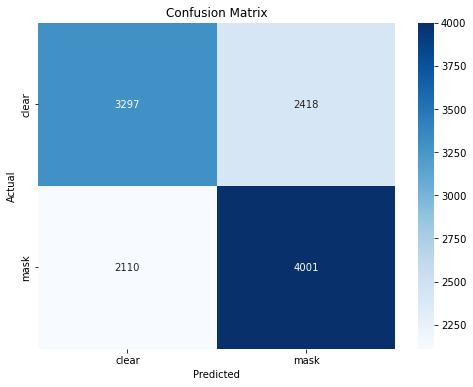

In [24]:
classes = np.unique(y_test)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

import matplotlib.pyplot as plt



precision: [0.60976512 0.62330581]
recall: [0.57690289 0.65472099]
fscore: [0.59287898 0.63862729]
support: [5715 6111]
